In [4]:
#https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/unet.ipynb#scrollTo=bdeDl5HO0QsY
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
#from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
#from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [5]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)     

In [6]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

--2022-05-15 11:26:07--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-05-15 11:26:07--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz.1’

images.tar.gz.1       0%[                    ]   1.06M  1.64MB/s               ^C
--2022-05-15 11:26:09--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... con

x images/British_Shorthair_72.jpg
x images/keeshond_151.jpg
x images/keeshond_86.jpg
x images/Bengal_125.jpg
x images/english_cocker_spaniel_185.jpg
x images/leonberger_143.jpg
x images/shiba_inu_33.jpg
x images/japanese_chin_78.jpg
x images/wheaten_terrier_15.jpg
x images/great_pyrenees_28.jpg
x images/Maine_Coon_69.jpg
x images/havanese_112.jpg
x images/saint_bernard_173.jpg
x images/Bombay_123.jpg
x images/pug_23.jpg
x images/chihuahua_20.jpg
x images/Sphynx_246.jpg
x images/english_cocker_spaniel_96.jpg
x images/Russian_Blue_119.jpg
x images/english_cocker_spaniel_57.jpg
x images/Bombay_205.jpg
x images/keeshond_190.jpg
x images/pomeranian_87.jpg
x images/basset_hound_113.jpg
x images/beagle_148.jpg
x images/British_Shorthair_199.jpg
x images/Sphynx_54.jpg
x images/yorkshire_terrier_126.jpg
x images/basset_hound_107.jpg
x images/yorkshire_terrier_3.jpg
x images/boxer_86.jpg
x images/basset_hound_112.jpg
x images/german_shorthaired_184.jpg
x images/shiba_inu_156.jpg
x images/beagle_

x images/Russian_Blue_129.jpg
x images/scottish_terrier_138.jpg
x images/shiba_inu_22.jpg
x images/miniature_pinscher_168.jpg
x images/pomeranian_157.jpg
x images/leonberger_111.jpg
x images/Russian_Blue_96.jpg
x images/english_setter_32.jpg
x images/Russian_Blue_118.jpg
x images/shiba_inu_21.jpg
x images/leonberger_82.jpg
x images/english_cocker_spaniel_14.jpg
x images/staffordshire_bull_terrier_112.jpg
x images/leonberger_19.jpg
x images/beagle_39.jpg
x images/Persian_174.jpg
x images/Ragdoll_119.jpg
x images/British_Shorthair_265.jpg
x images/havanese_138.jpg
x images/Abyssinian_173.jpg
x images/shiba_inu_41.jpg
x images/British_Shorthair_141.jpg
x images/english_cocker_spaniel_86.jpg
x images/miniature_pinscher_13.jpg
x images/Egyptian_Mau_188.jpg
x images/staffordshire_bull_terrier_200.jpg
x images/Abyssinian_220.jpg
x images/Russian_Blue_185.jpg
x images/havanese_22.jpg
x images/Bengal_101.jpg
x images/leonberger_68.jpg
x images/samoyed_41.jpg
x images/beagle_153.jpg
x images/Aby

x images/Bengal_138.jpg
x images/keeshond_180.jpg
x images/shiba_inu_57.jpg
x images/Abyssinian_204.jpg
x images/leonberger_132.jpg
x images/British_Shorthair_74.jpg
x images/wheaten_terrier_43.jpg
x images/beagle_102.jpg
x images/Siamese_106.jpg
x images/chihuahua_92.jpg
x images/Maine_Coon_104.jpg
x images/British_Shorthair_149.jpg
x images/British_Shorthair_163.jpg
x images/havanese_45.jpg
x images/leonberger_181.jpg
x images/Bombay_25.jpg
x images/Russian_Blue_78.jpg
x images/pug_169.jpg
x images/german_shorthaired_87.jpg
x images/newfoundland_26.jpg
x images/pomeranian_47.jpg
x images/boxer_59.jpg
x images/shiba_inu_13.jpg
x images/keeshond_157.jpg
x images/wheaten_terrier_116.jpg
x images/english_cocker_spaniel_167.jpg
x images/basset_hound_163.jpg
x images/British_Shorthair_158.jpg
x images/shiba_inu_124.jpg
x images/wheaten_terrier_76.jpg
x images/beagle_50.jpg
x images/english_cocker_spaniel_94.jpg
x images/pomeranian_56.jpg
x images/Persian_25.jpg
x images/pomeranian_85.jpg
x

x images/saint_bernard_22.jpg
x images/keeshond_112.jpg
x images/havanese_119.jpg
x images/basset_hound_122.jpg
x images/scottish_terrier_87.jpg
x images/Siamese_111.jpg
x images/Birman_55.jpg
x images/saint_bernard_28.jpg
x images/Maine_Coon_253.jpg
x images/Ragdoll_29.jpg
x images/miniature_pinscher_146.jpg
x images/japanese_chin_121.jpg
x images/Sphynx_232.jpg
x images/Russian_Blue_1.jpg
x images/havanese_172.jpg
x images/Bengal_87.jpg
x images/saint_bernard_188.jpg
x images/great_pyrenees_5.jpg
x images/British_Shorthair_51.jpg
x images/saint_bernard_153.jpg
x images/wheaten_terrier_46.jpg
x images/saint_bernard_115.jpg
x images/basset_hound_124.jpg
x images/samoyed_104.jpg
x images/wheaten_terrier_88.jpg
x images/saint_bernard_149.jpg
x images/great_pyrenees_95.jpg
x images/newfoundland_43.jpg
x images/Siamese_173.jpg
x images/keeshond_7.jpg
x images/British_Shorthair_34.jpg
x images/great_pyrenees_99.jpg
x images/Russian_Blue_67.jpg
x images/saint_bernard_30.jpg
x images/Maine_Co

x images/saint_bernard_26.jpg
x images/saint_bernard_134.jpg
x images/boxer_44.jpg
x images/Siamese_216.jpg
x images/great_pyrenees_92.jpg
x images/pug_87.jpg
x images/samoyed_143.jpg
x images/japanese_chin_175.jpg
x images/keeshond_133.jpg
x images/yorkshire_terrier_167.jpg
x images/basset_hound_57.jpg
x images/Egyptian_Mau_132.jpg
x images/Bengal_23.jpg
x images/german_shorthaired_142.jpg
x images/Birman_24.jpg
x images/beagle_58.jpg
x images/Birman_190.jpg
x images/newfoundland_80.jpg
x images/chihuahua_175.jpg
x images/japanese_chin_119.jpg
x images/Persian_169.jpg
x images/Persian_41.jpg
x images/samoyed_72.jpg
x images/Russian_Blue_220.jpg
x images/Maine_Coon_201.jpg
x images/japanese_chin_11.jpg
x images/german_shorthaired_8.jpg
x images/havanese_162.jpg
x images/english_cocker_spaniel_141.jpg
x images/Bombay_204.jpg
x images/Bombay_137.jpg
x images/boxer_48.jpg
x images/British_Shorthair_40.jpg
x images/miniature_pinscher_40.jpg
x images/scottish_terrier_57.jpg
x images/america

x images/Maine_Coon_149.jpg
x images/British_Shorthair_201.jpg
x images/chihuahua_185.jpg
x images/japanese_chin_129.jpg
x images/american_bulldog_207.jpg
x images/beagle_75.jpg
x images/american_pit_bull_terrier_99.jpg
x images/Ragdoll_52.jpg
x images/english_setter_196.jpg
x images/english_cocker_spaniel_134.jpg
x images/Sphynx_206.jpg
x images/japanese_chin_103.jpg
x images/yorkshire_terrier_34.jpg
x images/Bengal_155.jpg
x images/saint_bernard_102.jpg
x images/Persian_145.jpg
x images/Bombay_115.jpg
x images/pomeranian_172.jpg
x images/keeshond_100.jpg
x images/Persian_100.jpg
x images/pomeranian_54.jpg
x images/Bombay_77.jpg
x images/japanese_chin_142.jpg
x images/staffordshire_bull_terrier_15.jpg
x images/Russian_Blue_76.jpg
x images/samoyed_16.jpg
x images/Birman_4.jpg
x images/english_cocker_spaniel_133.jpg
x images/Abyssinian_96.jpg
x images/Maine_Coon_239.jpg
x images/keeshond_28.jpg
x images/great_pyrenees_196.jpg
x images/Birman_126.jpg
x images/yorkshire_terrier_157.jpg
x 

x images/keeshond_72.jpg
x images/Birman_198.jpg
x images/american_pit_bull_terrier_19.jpg
x images/Bombay_103.jpg
x images/Persian_255.jpg
x images/havanese_9.jpg
x images/miniature_pinscher_3.jpg
x images/Bombay_140.jpg
x images/pug_184.jpg
x images/german_shorthaired_151.jpg
x images/staffordshire_bull_terrier_169.jpg
x images/beagle_134.jpg
x images/shiba_inu_86.jpg
x images/Siamese_129.jpg
x images/newfoundland_20.jpg
x images/staffordshire_bull_terrier_181.jpg
x images/Bombay_213.jpg
x images/english_setter_186.jpg
x images/chihuahua_114.jpg
x images/japanese_chin_112.jpg
x images/Maine_Coon_167.jpg
x images/pug_96.jpg
x images/samoyed_119.jpg
x images/Ragdoll_104.jpg
x images/scottish_terrier_23.jpg
x images/Ragdoll_59.jpg
x images/Bombay_189.jpg
x images/pomeranian_116.jpg
x images/yorkshire_terrier_130.jpg
x images/scottish_terrier_129.jpg
x images/Ragdoll_6.jpg
x images/english_cocker_spaniel_47.jpg
x images/scottish_terrier_162.jpg
x images/Sphynx_117.jpg
x images/pug_59.jpg

x images/Birman_122.jpg
x images/german_shorthaired_152.jpg
x images/Siamese_104.jpg
x images/boxer_63.jpg
x images/Bengal_63.jpg
x images/basset_hound_191.jpg
x images/american_bulldog_140.jpg
x images/Sphynx_76.jpg
x images/basset_hound_142.jpg
x images/basset_hound_166.jpg
x images/great_pyrenees_157.jpg
x images/wheaten_terrier_89.jpg
x images/american_pit_bull_terrier_44.jpg
x images/Abyssinian_202.jpg
x images/Siamese_146.jpg
x images/newfoundland_141.jpg
x images/pomeranian_8.jpg
x images/wheaten_terrier_7.jpg
x images/scottish_terrier_189.jpg
x images/english_setter_91.jpg
x images/keeshond_67.jpg
x images/Sphynx_162.jpg
x images/keeshond_127.jpg
x images/pug_196.jpg
x images/staffordshire_bull_terrier_107.jpg
x images/Maine_Coon_34.jpg
x images/great_pyrenees_127.jpg
x images/Siamese_210.jpg
x images/english_setter_9.jpg
x images/wheaten_terrier_128.jpg
x images/english_cocker_spaniel_120.jpg
x images/miniature_pinscher_66.jpg
x images/saint_bernard_175.jpg
x images/pug_27.jpg

x images/British_Shorthair_59.jpg
x images/basset_hound_197.jpg
x images/great_pyrenees_43.jpg
x images/american_bulldog_66.jpg
x images/Maine_Coon_8.jpg
x images/great_pyrenees_177.jpg
x images/Maine_Coon_208.jpg
x images/pomeranian_107.jpg
x images/Siamese_162.jpg
x images/saint_bernard_146.jpg
x images/Ragdoll_149.jpg
x images/english_cocker_spaniel_188.jpg
x images/german_shorthaired_163.jpg
x images/basset_hound_99.jpg
x images/american_pit_bull_terrier_71.jpg
x images/english_setter_67.jpg
x images/english_cocker_spaniel_105.jpg
x images/yorkshire_terrier_184.jpg
x images/samoyed_95.jpg
x images/great_pyrenees_103.jpg
x images/Siamese_148.jpg
x images/newfoundland_6.jpg
x images/japanese_chin_83.jpg
x images/basset_hound_185.jpg
x images/Siamese_22.jpg
x images/Bombay_108.jpg
x images/Sphynx_145.jpg
x images/yorkshire_terrier_148.jpg
x images/Persian_6.jpg
x images/chihuahua_71.jpg
x images/leonberger_12.jpg
x images/japanese_chin_28.jpg
x images/Siamese_67.jpg
x images/chihuahua

x images/Ragdoll_255.jpg
x images/Birman_65.jpg
x images/pomeranian_170.jpg
x images/Persian_158.jpg
x images/wheaten_terrier_52.jpg
x images/english_setter_195.jpg
x images/newfoundland_61.jpg
x images/British_Shorthair_67.jpg
x images/scottish_terrier_139.jpg
x images/saint_bernard_117.jpg
x images/miniature_pinscher_133.jpg
x images/saint_bernard_160.jpg
x images/samoyed_134.jpg
x images/american_bulldog_119.jpg
x images/wheaten_terrier_45.jpg
x images/basset_hound_13.jpg
x images/german_shorthaired_140.jpg
x images/american_pit_bull_terrier_56.jpg
x images/leonberger_65.jpg
x images/Maine_Coon_254.jpg
x images/pug_161.jpg
x images/Bengal_51.jpg
x images/samoyed_32.jpg
x images/staffordshire_bull_terrier_110.jpg
x images/Egyptian_Mau_75.jpg
x images/american_pit_bull_terrier_100.jpg
x images/pomeranian_148.jpg
x images/havanese_88.jpg
x images/english_setter_152.jpg
x images/Russian_Blue_183.jpg
x images/Maine_Coon_54.jpg
x images/newfoundland_76.jpg
x images/Abyssinian_3.jpg
x imag

x images/newfoundland_53.jpg
x images/american_pit_bull_terrier_122.jpg
x images/american_pit_bull_terrier_88.jpg
x images/Sphynx_80.jpg
x images/yorkshire_terrier_57.jpg
x images/english_setter_150.jpg
x images/pomeranian_62.jpg
x images/Bengal_134.jpg
x images/american_pit_bull_terrier_6.jpg
x images/Siamese_140.jpg
x images/japanese_chin_123.jpg
x images/keeshond_114.jpg
x images/miniature_pinscher_22.jpg
x images/japanese_chin_35.jpg
x images/pomeranian_11.jpg
x images/english_setter_93.jpg
x images/Persian_269.jpg
x images/boxer_147.jpg
x images/pug_79.jpg
x images/keeshond_22.jpg
x images/wheaten_terrier_10.jpg
x images/Russian_Blue_244.jpg
x images/pomeranian_58.jpg
x images/Bengal_25.jpg
x images/pug_157.jpg
x images/wheaten_terrier_80.jpg
x images/english_setter_14.jpg
x images/Birman_139.jpg
x images/Bombay_37.jpg
x images/miniature_pinscher_161.jpg
x images/miniature_pinscher_41.jpg
x images/samoyed_196.jpg
x images/pug_58.jpg
x images/Birman_136.jpg
x images/samoyed_115.jpg

x images/yorkshire_terrier_14.jpg
x images/chihuahua_29.jpg
x images/american_bulldog_171.jpg
x images/japanese_chin_141.jpg
x images/american_bulldog_105.jpg
x images/Maine_Coon_227.jpg
x images/yorkshire_terrier_165.jpg
x images/Bombay_106.jpg
x images/english_setter_170.jpg
x images/english_setter_142.jpg
x images/chihuahua_112.jpg
x images/Ragdoll_51.jpg
x images/Abyssinian_7.jpg
x images/Birman_120.jpg
x images/Egyptian_Mau_187.jpg
x images/Russian_Blue_30.jpg
x images/Bengal_140.jpg
x images/Maine_Coon_186.jpg
x images/great_pyrenees_117.jpg
x images/staffordshire_bull_terrier_197.jpg
x images/Bengal_16.jpg
x images/Sphynx_183.jpg
x images/wheaten_terrier_172.jpg
x images/Bombay_152.jpg
x images/scottish_terrier_178.jpg
x images/staffordshire_bull_terrier_175.jpg
x images/newfoundland_32.jpg
x images/beagle_2.jpg
x images/Egyptian_Mau_81.jpg
x images/samoyed_43.jpg
x images/basset_hound_123.jpg
x images/staffordshire_bull_terrier_186.jpg
x images/american_bulldog_214.jpg
x images

x images/Ragdoll_71.jpg
x images/english_cocker_spaniel_194.jpg
x images/Persian_121.jpg
x images/staffordshire_bull_terrier_25.jpg
x images/beagle_147.jpg
x images/havanese_14.jpg
x images/pomeranian_20.jpg
x images/scottish_terrier_83.jpg
x images/chihuahua_36.jpg
x images/Abyssinian_128.jpg
x images/beagle_149.jpg
x images/British_Shorthair_188.jpg
x images/Bengal_182.jpg
x images/saint_bernard_138.jpg
x images/chihuahua_128.jpg
x images/Bengal_28.jpg
x images/american_bulldog_11.jpg
x images/saint_bernard_113.jpg
x images/american_pit_bull_terrier_61.jpg
x images/Sphynx_194.jpg
x images/keeshond_176.jpg
x images/shiba_inu_125.jpg
x images/newfoundland_9.jpg
x images/shiba_inu_153.jpg
x images/beagle_126.jpg
x images/Persian_171.jpg
x images/samoyed_156.jpg
x images/scottish_terrier_113.jpg
x images/Abyssinian_91.jpg
x images/pomeranian_97.jpg
x images/pomeranian_98.jpg
x images/japanese_chin_117.jpg
x images/scottish_terrier_135.jpg
x images/saint_bernard_106.jpg
x images/beagle_16

x images/american_bulldog_87.jpg
x images/miniature_pinscher_126.jpg
x images/havanese_134.jpg
x images/basset_hound_11.jpg
x images/pomeranian_6.jpg
x images/Maine_Coon_2.jpg
x images/samoyed_177.jpg
x images/shiba_inu_143.jpg
x images/boxer_70.jpg
x images/havanese_145.jpg
x images/Egyptian_Mau_146.jpg
x images/staffordshire_bull_terrier_121.jpg
x images/miniature_pinscher_144.jpg
x images/leonberger_76.jpg
x images/Bombay_125.jpg
x images/basset_hound_139.jpg
x images/japanese_chin_153.jpg
x images/scottish_terrier_1.jpg
x images/great_pyrenees_86.jpg
x images/pug_109.jpg
x images/samoyed_84.jpg
x images/Bombay_151.jpg
x images/Maine_Coon_189.jpg
x images/saint_bernard_55.jpg
x images/havanese_69.jpg
x images/saint_bernard_198.jpg
x images/wheaten_terrier_133.jpg
x images/saint_bernard_135.jpg
x images/Persian_270.jpg
x images/german_shorthaired_156.jpg
x images/scottish_terrier_35.jpg
x images/basset_hound_36.jpg
x images/pomeranian_169.jpg
x images/Birman_9.jpg
x images/samoyed_12

x images/Birman_26.jpg
x images/Bengal_81.jpg
x images/great_pyrenees_1.jpg
x images/english_cocker_spaniel_136.jpg
x images/samoyed_148.jpg
x images/leonberger_49.jpg
x images/newfoundland_44.jpg
x images/Birman_22.jpg
x images/Ragdoll_181.jpg
x images/german_shorthaired_65.jpg
x images/samoyed_37.jpg
x images/staffordshire_bull_terrier_149.jpg
x images/japanese_chin_44.jpg
x images/havanese_117.jpg
x images/Bombay_67.jpg
x images/Siamese_101.jpg
x images/Maine_Coon_49.jpg
x images/samoyed_54.jpg
x images/japanese_chin_8.jpg
x images/wheaten_terrier_161.jpg
x images/beagle_88.jpg
x images/shiba_inu_104.jpg
x images/staffordshire_bull_terrier_54.jpg
x images/British_Shorthair_136.jpg
x images/leonberger_188.jpg
x images/beagle_29.jpg
x images/newfoundland_28.jpg
x images/British_Shorthair_96.jpg
x images/samoyed_58.jpg
x images/Abyssinian_92.jpg
x images/miniature_pinscher_61.jpg
x images/Russian_Blue_135.jpg
x images/Bengal_98.jpg
x images/basset_hound_140.jpg
x images/Abyssinian_210.

x images/Abyssinian_102.mat
x images/Ragdoll_189.jpg
x images/havanese_56.jpg
x images/pug_119.jpg
x images/pug_111.jpg
x images/english_cocker_spaniel_62.jpg
x images/Persian_36.jpg
x images/german_shorthaired_118.jpg
x images/beagle_203.jpg
x images/British_Shorthair_55.jpg
x images/scottish_terrier_55.jpg
x images/shiba_inu_11.jpg
x images/saint_bernard_111.jpg
x images/keeshond_152.jpg
x images/german_shorthaired_115.jpg
x images/leonberger_32.jpg
x images/saint_bernard_99.jpg
x images/english_cocker_spaniel_152.jpg
x images/shiba_inu_180.jpg
x images/japanese_chin_192.jpg
x images/leonberger_156.jpg
x images/english_cocker_spaniel_44.jpg
x images/British_Shorthair_180.jpg
x images/Bombay_38.jpg
x images/american_pit_bull_terrier_91.jpg
x images/wheaten_terrier_141.jpg
x images/Birman_197.jpg
x images/newfoundland_113.jpg
x images/leonberger_30.jpg
x images/Abyssinian_213.jpg
x images/saint_bernard_33.jpg
x images/keeshond_107.jpg
x images/keeshond_30.jpg
x images/Bombay_170.jpg
x 

x images/english_setter_103.jpg
x images/samoyed_163.jpg
x images/keeshond_39.jpg
x images/yorkshire_terrier_51.jpg
x images/Russian_Blue_179.jpg
x images/Siamese_43.jpg
x images/american_bulldog_31.jpg
x images/scottish_terrier_126.jpg
x images/pug_93.jpg
x images/Siamese_141.jpg
x images/samoyed_190.jpg
x images/english_setter_191.jpg
x images/pug_151.jpg
x images/scottish_terrier_114.jpg
x images/Bengal_5.jpg
x images/boxer_176.jpg
x images/Bengal_154.jpg
x images/saint_bernard_101.jpg
x images/great_pyrenees_100.jpg
x images/miniature_pinscher_90.jpg
x images/Russian_Blue_262.jpg
x images/newfoundland_174.jpg
x images/beagle_18.jpg
x images/Sphynx_72.jpg
x images/Bengal_97.jpg
x images/Abyssinian_56.jpg
x images/boxer_27.jpg
x images/leonberger_137.jpg
x images/basset_hound_41.jpg
x images/Birman_131.jpg
x images/keeshond_61.jpg
x images/Birman_185.jpg
x images/basset_hound_168.jpg
x images/Russian_Blue_49.jpg
x images/Sphynx_245.jpg
x images/wheaten_terrier_113.jpg
x images/shiba_

x images/Egyptian_Mau_172.jpg
x images/english_setter_129.jpg
x images/beagle_27.jpg
x images/english_cocker_spaniel_4.jpg
x images/havanese_104.jpg
x images/keeshond_105.jpg
x images/miniature_pinscher_127.jpg
x images/english_setter_105.jpg
x images/Russian_Blue_133.jpg
x images/British_Shorthair_28.jpg
x images/staffordshire_bull_terrier_158.jpg
x images/Abyssinian_207.jpg
x images/Siamese_17.jpg
x images/japanese_chin_122.jpg
x images/Bombay_36.jpg
x images/British_Shorthair_78.jpg
x images/yorkshire_terrier_68.jpg
x images/Russian_Blue_80.jpg
x images/boxer_119.jpg
x images/leonberger_165.jpg
x images/samoyed_192.jpg
x images/Siamese_84.jpg
x images/Siamese_83.jpg
x images/Birman_121.jpg
x images/British_Shorthair_125.jpg
x images/pomeranian_76.jpg
x images/keeshond_17.jpg
x images/Egyptian_Mau_100.jpg
x images/Bengal_50.jpg
x images/Egyptian_Mau_110.jpg
x images/Birman_150.jpg
x images/miniature_pinscher_186.jpg
x images/german_shorthaired_31.jpg
x images/Siamese_110.jpg
x images

x images/great_pyrenees_53.jpg
x images/Persian_263.jpg
x images/keeshond_147.jpg
x images/Ragdoll_192.jpg
x images/Abyssinian_80.jpg
x images/yorkshire_terrier_128.jpg
x images/german_shorthaired_145.jpg
x images/Persian_239.jpg
x images/staffordshire_bull_terrier_65.jpg
x images/Birman_178.jpg
x images/Bombay_65.jpg
x images/chihuahua_28.jpg
x images/havanese_178.jpg
x images/english_setter_123.jpg
x images/basset_hound_71.jpg
x images/great_pyrenees_59.jpg
x images/scottish_terrier_66.jpg
x images/Abyssinian_118.jpg
x images/staffordshire_bull_terrier_83.jpg
x images/leonberger_113.jpg
x images/staffordshire_bull_terrier_88.jpg
x images/beagle_172.jpg
x images/staffordshire_bull_terrier_56.jpg
x images/Russian_Blue_86.jpg
x images/staffordshire_bull_terrier_41.jpg
x images/german_shorthaired_85.jpg
x images/yorkshire_terrier_28.jpg
x images/shiba_inu_160.jpg
x images/japanese_chin_53.jpg
x images/Bengal_92.jpg
x images/american_pit_bull_terrier_116.jpg
x images/saint_bernard_179.jpg

x images/Egyptian_Mau_163.jpg
x images/newfoundland_165.jpg
x images/yorkshire_terrier_38.jpg
x images/wheaten_terrier_99.jpg
x images/basset_hound_90.jpg
x images/keeshond_191.jpg
x images/Birman_77.jpg
x images/leonberger_150.jpg
x images/american_bulldog_205.jpg
x images/pomeranian_194.jpg
x images/havanese_107.jpg
x images/pug_154.jpg
x images/keeshond_62.jpg
x images/scottish_terrier_185.jpg
x images/havanese_115.jpg
x images/german_shorthaired_178.jpg
x images/scottish_terrier_171.jpg
x images/newfoundland_27.jpg
x images/Sphynx_46.jpg
x images/Ragdoll_174.jpg
x images/Russian_Blue_215.jpg
x images/keeshond_145.jpg
x images/shiba_inu_5.jpg
x images/Egyptian_Mau_25.jpg
x images/saint_bernard_93.jpg
x images/newfoundland_150.jpg
x images/British_Shorthair_153.jpg
x images/Egyptian_Mau_136.jpg
x images/wheaten_terrier_131.jpg
x images/shiba_inu_135.jpg
x images/staffordshire_bull_terrier_49.jpg
x images/basset_hound_10.jpg
x images/english_setter_179.jpg
x images/chihuahua_174.jpg
x

x images/great_pyrenees_54.jpg
x images/newfoundland_145.jpg
x images/beagle_83.jpg
x images/chihuahua_135.jpg
x images/miniature_pinscher_52.jpg
x images/english_setter_85.jpg
x images/german_shorthaired_147.jpg
x images/scottish_terrier_96.jpg
x images/keeshond_142.jpg
x images/Ragdoll_47.jpg
x images/Siamese_136.jpg
x images/japanese_chin_145.jpg
x images/Abyssinian_146.jpg
x images/Birman_27.jpg
x images/american_pit_bull_terrier_137.jpg
x images/havanese_200.jpg
x images/Sphynx_107.jpg
x images/leonberger_93.jpg
x images/yorkshire_terrier_77.jpg
x images/german_shorthaired_36.jpg
x images/pomeranian_131.jpg
x images/Bengal_60.jpg
x images/miniature_pinscher_91.jpg
x images/wheaten_terrier_57.jpg
x images/Sphynx_244.jpg
x images/Abyssinian_27.jpg
x images/Russian_Blue_18.jpg
x images/Egyptian_Mau_54.jpg
x images/american_bulldog_179.jpg
x images/samoyed_197.jpg
x images/english_setter_181.jpg
x images/keeshond_32.jpg
x images/pug_42.jpg
x images/Birman_134.jpg
x images/pomeranian_1

x images/Bengal_65.jpg
x images/Bengal_18.jpg
x images/Maine_Coon_80.jpg
x images/pomeranian_22.jpg
x images/Maine_Coon_187.jpg
x images/Russian_Blue_44.jpg
x images/american_bulldog_33.jpg
x images/leonberger_8.jpg
x images/leonberger_103.jpg
x images/american_pit_bull_terrier_161.jpg
x images/wheaten_terrier_53.jpg
x images/shiba_inu_92.jpg
x images/scottish_terrier_94.jpg
x images/yorkshire_terrier_25.jpg
x images/newfoundland_111.jpg
x images/pomeranian_126.jpg
x images/Siamese_21.jpg
x images/shiba_inu_78.jpg
x images/basset_hound_6.jpg
x images/japanese_chin_167.jpg
x images/pug_45.jpg
x images/great_pyrenees_129.jpg
x images/beagle_76.jpg
x images/beagle_45.jpg
x images/wheaten_terrier_146.jpg
x images/saint_bernard_194.jpg
x images/Ragdoll_30.jpg
x images/english_setter_50.jpg
x images/chihuahua_8.jpg
x images/chihuahua_57.jpg
x images/Bengal_39.jpg
x images/great_pyrenees_81.jpg
x images/german_shorthaired_179.jpg
x images/boxer_118.jpg
x images/miniature_pinscher_167.jpg
x im

x images/american_pit_bull_terrier_80.jpg
x images/British_Shorthair_185.jpg
x images/american_pit_bull_terrier_65.jpg
x images/Bengal_111.jpg
x images/Siamese_36.jpg
x images/yorkshire_terrier_80.jpg
x images/samoyed_50.jpg
x images/Egyptian_Mau_8.jpg
x images/Russian_Blue_178.jpg
x images/japanese_chin_183.jpg
x images/staffordshire_bull_terrier_59.jpg
x images/japanese_chin_152.jpg
x images/Ragdoll_185.jpg
x images/Russian_Blue_202.jpg
x images/Sphynx_30.jpg
x images/yorkshire_terrier_42.jpg
x images/english_cocker_spaniel_37.jpg
x images/scottish_terrier_182.jpg
x images/Persian_197.jpg
x images/Sphynx_9.jpg
x images/Maine_Coon_247.jpg
x images/Abyssinian_172.jpg
x images/Egyptian_Mau_182.jpg
x images/staffordshire_bull_terrier_4.jpg
x images/english_setter_154.jpg
x images/wheaten_terrier_183.jpg
x images/Maine_Coon_27.jpg
x images/leonberger_157.jpg
x images/great_pyrenees_57.jpg
x images/shiba_inu_183.jpg
x images/english_setter_80.jpg
x images/Siamese_254.jpg
x images/beagle_16

x images/shiba_inu_62.jpg
x images/Maine_Coon_219.jpg
x images/Egyptian_Mau_2.jpg
x images/chihuahua_147.jpg
x images/Sphynx_142.jpg
x images/great_pyrenees_111.jpg
x images/havanese_196.jpg
x images/Birman_128.jpg
x images/Bombay_39.jpg
x images/shiba_inu_178.jpg
x images/boxer_72.jpg
x images/miniature_pinscher_153.jpg
x images/great_pyrenees_125.jpg
x images/keeshond_85.jpg
x images/saint_bernard_157.jpg
x images/Birman_43.jpg
x images/yorkshire_terrier_134.jpg
x images/american_pit_bull_terrier_77.jpg
x images/pomeranian_30.jpg
x images/newfoundland_35.jpg
x images/Egyptian_Mau_219.jpg
x images/pomeranian_23.jpg
x images/basset_hound_199.jpg
x images/Bombay_220.jpg
x images/german_shorthaired_41.jpg
x images/Bombay_53.jpg
x images/newfoundland_137.jpg
x images/american_pit_bull_terrier_72.jpg
x images/pug_194.jpg
x images/yorkshire_terrier_124.jpg
x images/pomeranian_173.jpg
x annotations/
x annotations/list.txt
x annotations/README
x annotations/test.txt
x annotations/trainval.txt

x annotations/xmls/american_pit_bull_terrier_15.xml
x annotations/xmls/american_pit_bull_terrier_150.xml
x annotations/xmls/american_pit_bull_terrier_151.xml
x annotations/xmls/american_pit_bull_terrier_152.xml
x annotations/xmls/american_pit_bull_terrier_153.xml
x annotations/xmls/american_pit_bull_terrier_154.xml
x annotations/xmls/american_pit_bull_terrier_155.xml
x annotations/xmls/american_pit_bull_terrier_156.xml
x annotations/xmls/american_pit_bull_terrier_157.xml
x annotations/xmls/american_pit_bull_terrier_158.xml
x annotations/xmls/american_pit_bull_terrier_159.xml
x annotations/xmls/american_pit_bull_terrier_16.xml
x annotations/xmls/american_pit_bull_terrier_160.xml
x annotations/xmls/american_pit_bull_terrier_161.xml
x annotations/xmls/american_pit_bull_terrier_162.xml
x annotations/xmls/american_pit_bull_terrier_163.xml
x annotations/xmls/american_pit_bull_terrier_164.xml
x annotations/xmls/american_pit_bull_terrier_165.xml
x annotations/xmls/american_pit_bull_terrier_166

x annotations/xmls/Bengal_128.xml
x annotations/xmls/Bengal_129.xml
x annotations/xmls/Bengal_13.xml
x annotations/xmls/Bengal_130.xml
x annotations/xmls/Bengal_131.xml
x annotations/xmls/Bengal_132.xml
x annotations/xmls/Bengal_133.xml
x annotations/xmls/Bengal_134.xml
x annotations/xmls/Bengal_135.xml
x annotations/xmls/Bengal_136.xml
x annotations/xmls/Bengal_137.xml
x annotations/xmls/Bengal_138.xml
x annotations/xmls/Bengal_139.xml
x annotations/xmls/Bengal_14.xml
x annotations/xmls/Bengal_140.xml
x annotations/xmls/Bengal_141.xml
x annotations/xmls/Bengal_142.xml
x annotations/xmls/Bengal_143.xml
x annotations/xmls/Bengal_144.xml
x annotations/xmls/Bengal_145.xml
x annotations/xmls/Bengal_146.xml
x annotations/xmls/Bengal_147.xml
x annotations/xmls/Bengal_148.xml
x annotations/xmls/Bengal_149.xml
x annotations/xmls/Bengal_15.xml
x annotations/xmls/Bengal_150.xml
x annotations/xmls/Bengal_151.xml
x annotations/xmls/Bengal_152.xml
x annotations/xmls/Bengal_153.xml
x annotations/xml

x annotations/xmls/boxer_108.xml
x annotations/xmls/boxer_109.xml
x annotations/xmls/boxer_11.xml
x annotations/xmls/boxer_110.xml
x annotations/xmls/boxer_111.xml
x annotations/xmls/boxer_112.xml
x annotations/xmls/boxer_113.xml
x annotations/xmls/boxer_114.xml
x annotations/xmls/boxer_115.xml
x annotations/xmls/boxer_116.xml
x annotations/xmls/boxer_117.xml
x annotations/xmls/boxer_118.xml
x annotations/xmls/boxer_119.xml
x annotations/xmls/boxer_12.xml
x annotations/xmls/boxer_120.xml
x annotations/xmls/boxer_121.xml
x annotations/xmls/boxer_122.xml
x annotations/xmls/boxer_123.xml
x annotations/xmls/boxer_124.xml
x annotations/xmls/boxer_125.xml
x annotations/xmls/boxer_126.xml
x annotations/xmls/boxer_127.xml
x annotations/xmls/boxer_128.xml
x annotations/xmls/boxer_129.xml
x annotations/xmls/boxer_13.xml
x annotations/xmls/boxer_130.xml
x annotations/xmls/boxer_131.xml
x annotations/xmls/boxer_132.xml
x annotations/xmls/boxer_133.xml
x annotations/xmls/boxer_134.xml
x annotations

x annotations/xmls/chihuahua_127.xml
x annotations/xmls/chihuahua_128.xml
x annotations/xmls/chihuahua_129.xml
x annotations/xmls/chihuahua_13.xml
x annotations/xmls/chihuahua_130.xml
x annotations/xmls/chihuahua_131.xml
x annotations/xmls/chihuahua_132.xml
x annotations/xmls/chihuahua_133.xml
x annotations/xmls/chihuahua_134.xml
x annotations/xmls/chihuahua_135.xml
x annotations/xmls/chihuahua_136.xml
x annotations/xmls/chihuahua_137.xml
x annotations/xmls/chihuahua_138.xml
x annotations/xmls/chihuahua_139.xml
x annotations/xmls/chihuahua_14.xml
x annotations/xmls/chihuahua_140.xml
x annotations/xmls/chihuahua_141.xml
x annotations/xmls/chihuahua_142.xml
x annotations/xmls/chihuahua_143.xml
x annotations/xmls/chihuahua_144.xml
x annotations/xmls/chihuahua_145.xml
x annotations/xmls/chihuahua_146.xml
x annotations/xmls/chihuahua_147.xml
x annotations/xmls/chihuahua_148.xml
x annotations/xmls/chihuahua_149.xml
x annotations/xmls/chihuahua_15.xml
x annotations/xmls/chihuahua_150.xml
x an

x annotations/xmls/english_cocker_spaniel_173.xml
x annotations/xmls/english_cocker_spaniel_174.xml
x annotations/xmls/english_cocker_spaniel_175.xml
x annotations/xmls/english_cocker_spaniel_176.xml
x annotations/xmls/english_cocker_spaniel_177.xml
x annotations/xmls/english_cocker_spaniel_178.xml
x annotations/xmls/english_cocker_spaniel_179.xml
x annotations/xmls/english_cocker_spaniel_18.xml
x annotations/xmls/english_cocker_spaniel_180.xml
x annotations/xmls/english_cocker_spaniel_181.xml
x annotations/xmls/english_cocker_spaniel_182.xml
x annotations/xmls/english_cocker_spaniel_183.xml
x annotations/xmls/english_cocker_spaniel_184.xml
x annotations/xmls/english_cocker_spaniel_185.xml
x annotations/xmls/english_cocker_spaniel_186.xml
x annotations/xmls/english_cocker_spaniel_187.xml
x annotations/xmls/english_cocker_spaniel_188.xml
x annotations/xmls/english_cocker_spaniel_189.xml
x annotations/xmls/english_cocker_spaniel_190.xml
x annotations/xmls/english_setter_10.xml
x annotati

x annotations/xmls/great_pyrenees_132.xml
x annotations/xmls/great_pyrenees_133.xml
x annotations/xmls/great_pyrenees_134.xml
x annotations/xmls/great_pyrenees_135.xml
x annotations/xmls/great_pyrenees_136.xml
x annotations/xmls/great_pyrenees_137.xml
x annotations/xmls/great_pyrenees_138.xml
x annotations/xmls/great_pyrenees_139.xml
x annotations/xmls/great_pyrenees_14.xml
x annotations/xmls/great_pyrenees_140.xml
x annotations/xmls/great_pyrenees_141.xml
x annotations/xmls/great_pyrenees_142.xml
x annotations/xmls/great_pyrenees_143.xml
x annotations/xmls/great_pyrenees_144.xml
x annotations/xmls/great_pyrenees_145.xml
x annotations/xmls/great_pyrenees_146.xml
x annotations/xmls/great_pyrenees_147.xml
x annotations/xmls/great_pyrenees_148.xml
x annotations/xmls/great_pyrenees_149.xml
x annotations/xmls/great_pyrenees_15.xml
x annotations/xmls/great_pyrenees_150.xml
x annotations/xmls/great_pyrenees_151.xml
x annotations/xmls/great_pyrenees_152.xml
x annotations/xmls/great_pyrenees_15

x annotations/xmls/keeshond_117.xml
x annotations/xmls/keeshond_118.xml
x annotations/xmls/keeshond_119.xml
x annotations/xmls/keeshond_12.xml
x annotations/xmls/keeshond_120.xml
x annotations/xmls/keeshond_121.xml
x annotations/xmls/keeshond_122.xml
x annotations/xmls/keeshond_123.xml
x annotations/xmls/keeshond_124.xml
x annotations/xmls/keeshond_125.xml
x annotations/xmls/keeshond_126.xml
x annotations/xmls/keeshond_127.xml
x annotations/xmls/keeshond_128.xml
x annotations/xmls/keeshond_129.xml
x annotations/xmls/keeshond_13.xml
x annotations/xmls/keeshond_130.xml
x annotations/xmls/keeshond_131.xml
x annotations/xmls/keeshond_132.xml
x annotations/xmls/keeshond_133.xml
x annotations/xmls/keeshond_134.xml
x annotations/xmls/keeshond_135.xml
x annotations/xmls/keeshond_136.xml
x annotations/xmls/keeshond_137.xml
x annotations/xmls/keeshond_138.xml
x annotations/xmls/keeshond_139.xml
x annotations/xmls/keeshond_14.xml
x annotations/xmls/keeshond_140.xml
x annotations/xmls/keeshond_141

x annotations/xmls/miniature_pinscher_109.xml
x annotations/xmls/miniature_pinscher_11.xml
x annotations/xmls/miniature_pinscher_110.xml
x annotations/xmls/miniature_pinscher_111.xml
x annotations/xmls/miniature_pinscher_112.xml
x annotations/xmls/miniature_pinscher_113.xml
x annotations/xmls/miniature_pinscher_114.xml
x annotations/xmls/miniature_pinscher_115.xml
x annotations/xmls/miniature_pinscher_116.xml
x annotations/xmls/miniature_pinscher_117.xml
x annotations/xmls/miniature_pinscher_118.xml
x annotations/xmls/miniature_pinscher_119.xml
x annotations/xmls/miniature_pinscher_12.xml
x annotations/xmls/miniature_pinscher_120.xml
x annotations/xmls/miniature_pinscher_121.xml
x annotations/xmls/miniature_pinscher_122.xml
x annotations/xmls/miniature_pinscher_123.xml
x annotations/xmls/miniature_pinscher_124.xml
x annotations/xmls/miniature_pinscher_125.xml
x annotations/xmls/miniature_pinscher_126.xml
x annotations/xmls/miniature_pinscher_127.xml
x annotations/xmls/miniature_pinsche

x annotations/xmls/Persian_102.xml
x annotations/xmls/Persian_103.xml
x annotations/xmls/Persian_104.xml
x annotations/xmls/Persian_105.xml
x annotations/xmls/Persian_106.xml
x annotations/xmls/Persian_107.xml
x annotations/xmls/Persian_108.xml
x annotations/xmls/Persian_11.xml
x annotations/xmls/Persian_111.xml
x annotations/xmls/Persian_112.xml
x annotations/xmls/Persian_114.xml
x annotations/xmls/Persian_115.xml
x annotations/xmls/Persian_116.xml
x annotations/xmls/Persian_117.xml
x annotations/xmls/Persian_118.xml
x annotations/xmls/Persian_12.xml
x annotations/xmls/Persian_120.xml
x annotations/xmls/Persian_121.xml
x annotations/xmls/Persian_122.xml
x annotations/xmls/Persian_123.xml
x annotations/xmls/Persian_125.xml
x annotations/xmls/Persian_126.xml
x annotations/xmls/Persian_128.xml
x annotations/xmls/Persian_129.xml
x annotations/xmls/Persian_13.xml
x annotations/xmls/Persian_131.xml
x annotations/xmls/Persian_132.xml
x annotations/xmls/Persian_133.xml
x annotations/xmls/Pers

x annotations/xmls/pug_180.xml
x annotations/xmls/pug_181.xml
x annotations/xmls/pug_182.xml
x annotations/xmls/pug_183.xml
x annotations/xmls/pug_184.xml
x annotations/xmls/pug_185.xml
x annotations/xmls/pug_186.xml
x annotations/xmls/pug_187.xml
x annotations/xmls/pug_188.xml
x annotations/xmls/pug_189.xml
x annotations/xmls/pug_190.xml
x annotations/xmls/pug_191.xml
x annotations/xmls/pug_192.xml
x annotations/xmls/Ragdoll_1.xml
x annotations/xmls/Ragdoll_10.xml
x annotations/xmls/Ragdoll_100.xml
x annotations/xmls/Ragdoll_101.xml
x annotations/xmls/Ragdoll_103.xml
x annotations/xmls/Ragdoll_104.xml
x annotations/xmls/Ragdoll_105.xml
x annotations/xmls/Ragdoll_106.xml
x annotations/xmls/Ragdoll_107.xml
x annotations/xmls/Ragdoll_110.xml
x annotations/xmls/Ragdoll_111.xml
x annotations/xmls/Ragdoll_112.xml
x annotations/xmls/Ragdoll_113.xml
x annotations/xmls/Ragdoll_114.xml
x annotations/xmls/Ragdoll_115.xml
x annotations/xmls/Ragdoll_116.xml
x annotations/xmls/Ragdoll_117.xml
x ann

x annotations/xmls/saint_bernard_16.xml
x annotations/xmls/saint_bernard_160.xml
x annotations/xmls/saint_bernard_161.xml
x annotations/xmls/saint_bernard_162.xml
x annotations/xmls/saint_bernard_163.xml
x annotations/xmls/saint_bernard_164.xml
x annotations/xmls/saint_bernard_165.xml
x annotations/xmls/saint_bernard_166.xml
x annotations/xmls/saint_bernard_167.xml
x annotations/xmls/saint_bernard_168.xml
x annotations/xmls/saint_bernard_169.xml
x annotations/xmls/saint_bernard_17.xml
x annotations/xmls/saint_bernard_170.xml
x annotations/xmls/saint_bernard_171.xml
x annotations/xmls/saint_bernard_172.xml
x annotations/xmls/saint_bernard_173.xml
x annotations/xmls/saint_bernard_174.xml
x annotations/xmls/saint_bernard_175.xml
x annotations/xmls/saint_bernard_176.xml
x annotations/xmls/saint_bernard_177.xml
x annotations/xmls/saint_bernard_178.xml
x annotations/xmls/saint_bernard_179.xml
x annotations/xmls/saint_bernard_18.xml
x annotations/xmls/saint_bernard_180.xml
x annotations/xmls/

x annotations/xmls/shiba_inu_117.xml
x annotations/xmls/shiba_inu_118.xml
x annotations/xmls/shiba_inu_119.xml
x annotations/xmls/shiba_inu_12.xml
x annotations/xmls/shiba_inu_120.xml
x annotations/xmls/shiba_inu_121.xml
x annotations/xmls/shiba_inu_122.xml
x annotations/xmls/shiba_inu_123.xml
x annotations/xmls/shiba_inu_124.xml
x annotations/xmls/shiba_inu_125.xml
x annotations/xmls/shiba_inu_126.xml
x annotations/xmls/shiba_inu_127.xml
x annotations/xmls/shiba_inu_128.xml
x annotations/xmls/shiba_inu_129.xml
x annotations/xmls/shiba_inu_13.xml
x annotations/xmls/shiba_inu_130.xml
x annotations/xmls/shiba_inu_131.xml
x annotations/xmls/shiba_inu_132.xml
x annotations/xmls/shiba_inu_133.xml
x annotations/xmls/shiba_inu_134.xml
x annotations/xmls/shiba_inu_135.xml
x annotations/xmls/shiba_inu_136.xml
x annotations/xmls/shiba_inu_137.xml
x annotations/xmls/shiba_inu_139.xml
x annotations/xmls/shiba_inu_14.xml
x annotations/xmls/shiba_inu_140.xml
x annotations/xmls/shiba_inu_141.xml
x an

x annotations/xmls/Sphynx_166.xml
x annotations/xmls/Sphynx_167.xml
x annotations/xmls/Sphynx_168.xml
x annotations/xmls/Sphynx_169.xml
x annotations/xmls/Sphynx_17.xml
x annotations/xmls/Sphynx_170.xml
x annotations/xmls/Sphynx_171.xml
x annotations/xmls/Sphynx_172.xml
x annotations/xmls/Sphynx_173.xml
x annotations/xmls/Sphynx_174.xml
x annotations/xmls/Sphynx_175.xml
x annotations/xmls/Sphynx_176.xml
x annotations/xmls/Sphynx_177.xml
x annotations/xmls/Sphynx_178.xml
x annotations/xmls/Sphynx_179.xml
x annotations/xmls/Sphynx_18.xml
x annotations/xmls/Sphynx_180.xml
x annotations/xmls/Sphynx_181.xml
x annotations/xmls/Sphynx_182.xml
x annotations/xmls/Sphynx_183.xml
x annotations/xmls/Sphynx_184.xml
x annotations/xmls/Sphynx_185.xml
x annotations/xmls/Sphynx_186.xml
x annotations/xmls/Sphynx_187.xml
x annotations/xmls/Sphynx_188.xml
x annotations/xmls/Sphynx_189.xml
x annotations/xmls/Sphynx_19.xml
x annotations/xmls/Sphynx_190.xml
x annotations/xmls/Sphynx_191.xml
x annotations/xml

x annotations/xmls/wheaten_terrier_174.xml
x annotations/xmls/wheaten_terrier_175.xml
x annotations/xmls/wheaten_terrier_176.xml
x annotations/xmls/wheaten_terrier_177.xml
x annotations/xmls/wheaten_terrier_178.xml
x annotations/xmls/wheaten_terrier_179.xml
x annotations/xmls/wheaten_terrier_18.xml
x annotations/xmls/wheaten_terrier_180.xml
x annotations/xmls/wheaten_terrier_181.xml
x annotations/xmls/wheaten_terrier_182.xml
x annotations/xmls/wheaten_terrier_183.xml
x annotations/xmls/wheaten_terrier_184.xml
x annotations/xmls/wheaten_terrier_185.xml
x annotations/xmls/wheaten_terrier_186.xml
x annotations/xmls/wheaten_terrier_187.xml
x annotations/xmls/wheaten_terrier_188.xml
x annotations/xmls/wheaten_terrier_189.xml
x annotations/xmls/wheaten_terrier_190.xml
x annotations/xmls/yorkshire_terrier_10.xml
x annotations/xmls/yorkshire_terrier_100.xml
x annotations/xmls/yorkshire_terrier_101.xml
x annotations/xmls/yorkshire_terrier_102.xml
x annotations/xmls/yorkshire_terrier_103.xml
x a

x annotations/trimaps/Abyssinian_197.png
x annotations/trimaps/Abyssinian_2.png
x annotations/trimaps/Abyssinian_20.png
x annotations/trimaps/Abyssinian_201.png
x annotations/trimaps/Abyssinian_202.png
x annotations/trimaps/Abyssinian_204.png
x annotations/trimaps/Abyssinian_205.png
x annotations/trimaps/Abyssinian_206.png
x annotations/trimaps/Abyssinian_207.png
x annotations/trimaps/Abyssinian_21.png
x annotations/trimaps/Abyssinian_210.png
x annotations/trimaps/Abyssinian_212.png
x annotations/trimaps/Abyssinian_213.png
x annotations/trimaps/Abyssinian_215.png
x annotations/trimaps/Abyssinian_216.png
x annotations/trimaps/Abyssinian_217.png
x annotations/trimaps/Abyssinian_219.png
x annotations/trimaps/Abyssinian_22.png
x annotations/trimaps/Abyssinian_220.png
x annotations/trimaps/Abyssinian_221.png
x annotations/trimaps/Abyssinian_223.png
x annotations/trimaps/Abyssinian_224.png
x annotations/trimaps/Abyssinian_225.png
x annotations/trimaps/Abyssinian_226.png
x annotations/trimaps

x annotations/trimaps/american_bulldog_207.png
x annotations/trimaps/american_bulldog_208.png
x annotations/trimaps/american_bulldog_209.png
x annotations/trimaps/american_bulldog_21.png
x annotations/trimaps/american_bulldog_211.png
x annotations/trimaps/american_bulldog_212.png
x annotations/trimaps/american_bulldog_214.png
x annotations/trimaps/american_bulldog_216.png
x annotations/trimaps/american_bulldog_217.png
x annotations/trimaps/american_bulldog_218.png
x annotations/trimaps/american_bulldog_22.png
x annotations/trimaps/american_bulldog_220.png
x annotations/trimaps/american_bulldog_221.png
x annotations/trimaps/american_bulldog_224.png
x annotations/trimaps/american_bulldog_23.png
x annotations/trimaps/american_bulldog_24.png
x annotations/trimaps/american_bulldog_25.png
x annotations/trimaps/american_bulldog_26.png
x annotations/trimaps/american_bulldog_27.png
x annotations/trimaps/american_bulldog_28.png
x annotations/trimaps/american_bulldog_29.png
x annotations/trimaps/

x annotations/trimaps/american_pit_bull_terrier_18.png
x annotations/trimaps/american_pit_bull_terrier_180.png
x annotations/trimaps/american_pit_bull_terrier_181.png
x annotations/trimaps/american_pit_bull_terrier_182.png
x annotations/trimaps/american_pit_bull_terrier_183.png
x annotations/trimaps/american_pit_bull_terrier_184.png
x annotations/trimaps/american_pit_bull_terrier_185.png
x annotations/trimaps/american_pit_bull_terrier_186.png
x annotations/trimaps/american_pit_bull_terrier_187.png
x annotations/trimaps/american_pit_bull_terrier_188.png
x annotations/trimaps/american_pit_bull_terrier_189.png
x annotations/trimaps/american_pit_bull_terrier_19.png
x annotations/trimaps/american_pit_bull_terrier_190.png
x annotations/trimaps/american_pit_bull_terrier_191.png
x annotations/trimaps/american_pit_bull_terrier_192.png
x annotations/trimaps/american_pit_bull_terrier_193.png
x annotations/trimaps/american_pit_bull_terrier_194.png
x annotations/trimaps/american_pit_bull_terrier_19

x annotations/trimaps/basset_hound_144.png
x annotations/trimaps/basset_hound_145.png
x annotations/trimaps/basset_hound_146.png
x annotations/trimaps/basset_hound_147.png
x annotations/trimaps/basset_hound_148.png
x annotations/trimaps/basset_hound_149.png
x annotations/trimaps/basset_hound_15.png
x annotations/trimaps/basset_hound_150.png
x annotations/trimaps/basset_hound_151.png
x annotations/trimaps/basset_hound_152.png
x annotations/trimaps/basset_hound_153.png
x annotations/trimaps/basset_hound_154.png
x annotations/trimaps/basset_hound_155.png
x annotations/trimaps/basset_hound_156.png
x annotations/trimaps/basset_hound_157.png
x annotations/trimaps/basset_hound_158.png
x annotations/trimaps/basset_hound_159.png
x annotations/trimaps/basset_hound_16.png
x annotations/trimaps/basset_hound_160.png
x annotations/trimaps/basset_hound_161.png
x annotations/trimaps/basset_hound_162.png
x annotations/trimaps/basset_hound_163.png
x annotations/trimaps/basset_hound_164.png
x annotations

x annotations/trimaps/beagle_149.png
x annotations/trimaps/beagle_15.png
x annotations/trimaps/beagle_150.png
x annotations/trimaps/beagle_151.png
x annotations/trimaps/beagle_152.png
x annotations/trimaps/beagle_153.png
x annotations/trimaps/beagle_154.png
x annotations/trimaps/beagle_155.png
x annotations/trimaps/beagle_156.png
x annotations/trimaps/beagle_157.png
x annotations/trimaps/beagle_158.png
x annotations/trimaps/beagle_16.png
x annotations/trimaps/beagle_160.png
x annotations/trimaps/beagle_161.png
x annotations/trimaps/beagle_162.png
x annotations/trimaps/beagle_163.png
x annotations/trimaps/beagle_164.png
x annotations/trimaps/beagle_165.png
x annotations/trimaps/beagle_166.png
x annotations/trimaps/beagle_167.png
x annotations/trimaps/beagle_168.png
x annotations/trimaps/beagle_169.png
x annotations/trimaps/beagle_17.png
x annotations/trimaps/beagle_170.png
x annotations/trimaps/beagle_171.png
x annotations/trimaps/beagle_172.png
x annotations/trimaps/beagle_173.png
x an

x annotations/trimaps/Bengal_170.png
x annotations/trimaps/Bengal_171.png
x annotations/trimaps/Bengal_172.png
x annotations/trimaps/Bengal_173.png
x annotations/trimaps/Bengal_174.png
x annotations/trimaps/Bengal_175.png
x annotations/trimaps/Bengal_176.png
x annotations/trimaps/Bengal_177.png
x annotations/trimaps/Bengal_178.png
x annotations/trimaps/Bengal_179.png
x annotations/trimaps/Bengal_18.png
x annotations/trimaps/Bengal_180.png
x annotations/trimaps/Bengal_182.png
x annotations/trimaps/Bengal_183.png
x annotations/trimaps/Bengal_184.png
x annotations/trimaps/Bengal_185.png
x annotations/trimaps/Bengal_186.png
x annotations/trimaps/Bengal_187.png
x annotations/trimaps/Bengal_188.png
x annotations/trimaps/Bengal_189.png
x annotations/trimaps/Bengal_19.png
x annotations/trimaps/Bengal_190.png
x annotations/trimaps/Bengal_191.png
x annotations/trimaps/Bengal_192.png
x annotations/trimaps/Bengal_193.png
x annotations/trimaps/Bengal_194.png
x annotations/trimaps/Bengal_195.png
x a

x annotations/trimaps/Birman_2.png
x annotations/trimaps/Birman_20.png
x annotations/trimaps/Birman_200.png
x annotations/trimaps/Birman_201.png
x annotations/trimaps/Birman_21.png
x annotations/trimaps/Birman_22.png
x annotations/trimaps/Birman_23.png
x annotations/trimaps/Birman_24.png
x annotations/trimaps/Birman_25.png
x annotations/trimaps/Birman_26.png
x annotations/trimaps/Birman_27.png
x annotations/trimaps/Birman_28.png
x annotations/trimaps/Birman_29.png
x annotations/trimaps/Birman_3.png
x annotations/trimaps/Birman_30.png
x annotations/trimaps/Birman_31.png
x annotations/trimaps/Birman_32.png
x annotations/trimaps/Birman_33.png
x annotations/trimaps/Birman_34.png
x annotations/trimaps/Birman_35.png
x annotations/trimaps/Birman_36.png
x annotations/trimaps/Birman_37.png
x annotations/trimaps/Birman_38.png
x annotations/trimaps/Birman_39.png
x annotations/trimaps/Birman_4.png
x annotations/trimaps/Birman_40.png
x annotations/trimaps/Birman_41.png
x annotations/trimaps/Birman_

x annotations/trimaps/Bombay_59.png
x annotations/trimaps/Bombay_6.png
x annotations/trimaps/Bombay_60.png
x annotations/trimaps/Bombay_61.png
x annotations/trimaps/Bombay_62.png
x annotations/trimaps/Bombay_63.png
x annotations/trimaps/Bombay_64.png
x annotations/trimaps/Bombay_65.png
x annotations/trimaps/Bombay_66.png
x annotations/trimaps/Bombay_67.png
x annotations/trimaps/Bombay_68.png
x annotations/trimaps/Bombay_69.png
x annotations/trimaps/Bombay_7.png
x annotations/trimaps/Bombay_70.png
x annotations/trimaps/Bombay_71.png
x annotations/trimaps/Bombay_72.png
x annotations/trimaps/Bombay_73.png
x annotations/trimaps/Bombay_74.png
x annotations/trimaps/Bombay_75.png
x annotations/trimaps/Bombay_76.png
x annotations/trimaps/Bombay_77.png
x annotations/trimaps/Bombay_78.png
x annotations/trimaps/Bombay_79.png
x annotations/trimaps/Bombay_8.png
x annotations/trimaps/Bombay_80.png
x annotations/trimaps/Bombay_81.png
x annotations/trimaps/Bombay_82.png
x annotations/trimaps/Bombay_83

x annotations/trimaps/British_Shorthair_106.png
x annotations/trimaps/British_Shorthair_107.png
x annotations/trimaps/British_Shorthair_108.png
x annotations/trimaps/British_Shorthair_109.png
x annotations/trimaps/British_Shorthair_110.png
x annotations/trimaps/British_Shorthair_111.png
x annotations/trimaps/British_Shorthair_112.png
x annotations/trimaps/British_Shorthair_113.png
x annotations/trimaps/British_Shorthair_114.png
x annotations/trimaps/British_Shorthair_115.png
x annotations/trimaps/British_Shorthair_116.png
x annotations/trimaps/British_Shorthair_117.png
x annotations/trimaps/British_Shorthair_118.png
x annotations/trimaps/British_Shorthair_119.png
x annotations/trimaps/British_Shorthair_120.png
x annotations/trimaps/British_Shorthair_121.png
x annotations/trimaps/British_Shorthair_122.png
x annotations/trimaps/British_Shorthair_123.png
x annotations/trimaps/British_Shorthair_124.png
x annotations/trimaps/British_Shorthair_125.png
x annotations/trimaps/British_Shorthair_

x annotations/trimaps/British_Shorthair_84.png
x annotations/trimaps/British_Shorthair_85.png
x annotations/trimaps/British_Shorthair_86.png
x annotations/trimaps/British_Shorthair_87.png
x annotations/trimaps/British_Shorthair_88.png
x annotations/trimaps/British_Shorthair_89.png
x annotations/trimaps/British_Shorthair_9.png
x annotations/trimaps/British_Shorthair_90.png
x annotations/trimaps/British_Shorthair_91.png
x annotations/trimaps/British_Shorthair_92.png
x annotations/trimaps/British_Shorthair_93.png
x annotations/trimaps/British_Shorthair_94.png
x annotations/trimaps/British_Shorthair_95.png
x annotations/trimaps/British_Shorthair_96.png
x annotations/trimaps/British_Shorthair_97.png
x annotations/trimaps/British_Shorthair_98.png
x annotations/trimaps/British_Shorthair_99.png
x annotations/trimaps/chihuahua_1.png
x annotations/trimaps/chihuahua_10.png
x annotations/trimaps/chihuahua_100.png
x annotations/trimaps/chihuahua_101.png
x annotations/trimaps/chihuahua_102.png
x ann

x annotations/trimaps/chihuahua_99.png
x annotations/trimaps/Egyptian_Mau_1.png
x annotations/trimaps/Egyptian_Mau_10.png
x annotations/trimaps/Egyptian_Mau_100.png
x annotations/trimaps/Egyptian_Mau_101.png
x annotations/trimaps/Egyptian_Mau_102.png
x annotations/trimaps/Egyptian_Mau_103.png
x annotations/trimaps/Egyptian_Mau_104.png
x annotations/trimaps/Egyptian_Mau_105.png
x annotations/trimaps/Egyptian_Mau_106.png
x annotations/trimaps/Egyptian_Mau_107.png
x annotations/trimaps/Egyptian_Mau_108.png
x annotations/trimaps/Egyptian_Mau_109.png
x annotations/trimaps/Egyptian_Mau_11.png
x annotations/trimaps/Egyptian_Mau_110.png
x annotations/trimaps/Egyptian_Mau_111.png
x annotations/trimaps/Egyptian_Mau_112.png
x annotations/trimaps/Egyptian_Mau_113.png
x annotations/trimaps/Egyptian_Mau_114.png
x annotations/trimaps/Egyptian_Mau_115.png
x annotations/trimaps/Egyptian_Mau_116.png
x annotations/trimaps/Egyptian_Mau_117.png
x annotations/trimaps/Egyptian_Mau_118.png
x annotations/trima

x annotations/trimaps/english_cocker_spaniel_111.png
x annotations/trimaps/english_cocker_spaniel_112.png
x annotations/trimaps/english_cocker_spaniel_113.png
x annotations/trimaps/english_cocker_spaniel_114.png
x annotations/trimaps/english_cocker_spaniel_115.png
x annotations/trimaps/english_cocker_spaniel_116.png
x annotations/trimaps/english_cocker_spaniel_117.png
x annotations/trimaps/english_cocker_spaniel_118.png
x annotations/trimaps/english_cocker_spaniel_119.png
x annotations/trimaps/english_cocker_spaniel_12.png
x annotations/trimaps/english_cocker_spaniel_120.png
x annotations/trimaps/english_cocker_spaniel_121.png
x annotations/trimaps/english_cocker_spaniel_122.png
x annotations/trimaps/english_cocker_spaniel_123.png
x annotations/trimaps/english_cocker_spaniel_124.png
x annotations/trimaps/english_cocker_spaniel_125.png
x annotations/trimaps/english_cocker_spaniel_126.png
x annotations/trimaps/english_cocker_spaniel_127.png
x annotations/trimaps/english_cocker_spaniel_12

x annotations/trimaps/english_cocker_spaniel_72.png
x annotations/trimaps/english_cocker_spaniel_73.png
x annotations/trimaps/english_cocker_spaniel_74.png
x annotations/trimaps/english_cocker_spaniel_75.png
x annotations/trimaps/english_cocker_spaniel_76.png
x annotations/trimaps/english_cocker_spaniel_77.png
x annotations/trimaps/english_cocker_spaniel_78.png
x annotations/trimaps/english_cocker_spaniel_79.png
x annotations/trimaps/english_cocker_spaniel_8.png
x annotations/trimaps/english_cocker_spaniel_80.png
x annotations/trimaps/english_cocker_spaniel_81.png
x annotations/trimaps/english_cocker_spaniel_82.png
x annotations/trimaps/english_cocker_spaniel_83.png
x annotations/trimaps/english_cocker_spaniel_84.png
x annotations/trimaps/english_cocker_spaniel_85.png
x annotations/trimaps/english_cocker_spaniel_86.png
x annotations/trimaps/english_cocker_spaniel_87.png
x annotations/trimaps/english_cocker_spaniel_88.png
x annotations/trimaps/english_cocker_spaniel_89.png
x annotations

x annotations/trimaps/english_setter_54.png
x annotations/trimaps/english_setter_55.png
x annotations/trimaps/english_setter_56.png
x annotations/trimaps/english_setter_57.png
x annotations/trimaps/english_setter_58.png
x annotations/trimaps/english_setter_59.png
x annotations/trimaps/english_setter_6.png
x annotations/trimaps/english_setter_60.png
x annotations/trimaps/english_setter_61.png
x annotations/trimaps/english_setter_62.png
x annotations/trimaps/english_setter_63.png
x annotations/trimaps/english_setter_64.png
x annotations/trimaps/english_setter_65.png
x annotations/trimaps/english_setter_66.png
x annotations/trimaps/english_setter_67.png
x annotations/trimaps/english_setter_68.png
x annotations/trimaps/english_setter_69.png
x annotations/trimaps/english_setter_7.png
x annotations/trimaps/english_setter_70.png
x annotations/trimaps/english_setter_71.png
x annotations/trimaps/english_setter_72.png
x annotations/trimaps/english_setter_73.png
x annotations/trimaps/english_sett

x annotations/trimaps/german_shorthaired_34.png
x annotations/trimaps/german_shorthaired_35.png
x annotations/trimaps/german_shorthaired_36.png
x annotations/trimaps/german_shorthaired_37.png
x annotations/trimaps/german_shorthaired_38.png
x annotations/trimaps/german_shorthaired_39.png
x annotations/trimaps/german_shorthaired_4.png
x annotations/trimaps/german_shorthaired_40.png
x annotations/trimaps/german_shorthaired_41.png
x annotations/trimaps/german_shorthaired_42.png
x annotations/trimaps/german_shorthaired_43.png
x annotations/trimaps/german_shorthaired_44.png
x annotations/trimaps/german_shorthaired_45.png
x annotations/trimaps/german_shorthaired_46.png
x annotations/trimaps/german_shorthaired_47.png
x annotations/trimaps/german_shorthaired_48.png
x annotations/trimaps/german_shorthaired_49.png
x annotations/trimaps/german_shorthaired_5.png
x annotations/trimaps/german_shorthaired_50.png
x annotations/trimaps/german_shorthaired_51.png
x annotations/trimaps/german_shorthaired_5

x annotations/trimaps/great_pyrenees_23.png
x annotations/trimaps/great_pyrenees_24.png
x annotations/trimaps/great_pyrenees_25.png
x annotations/trimaps/great_pyrenees_26.png
x annotations/trimaps/great_pyrenees_27.png
x annotations/trimaps/great_pyrenees_28.png
x annotations/trimaps/great_pyrenees_29.png
x annotations/trimaps/great_pyrenees_3.png
x annotations/trimaps/great_pyrenees_30.png
x annotations/trimaps/great_pyrenees_31.png
x annotations/trimaps/great_pyrenees_32.png
x annotations/trimaps/great_pyrenees_33.png
x annotations/trimaps/great_pyrenees_34.png
x annotations/trimaps/great_pyrenees_35.png
x annotations/trimaps/great_pyrenees_36.png
x annotations/trimaps/great_pyrenees_37.png
x annotations/trimaps/great_pyrenees_38.png
x annotations/trimaps/great_pyrenees_39.png
x annotations/trimaps/great_pyrenees_4.png
x annotations/trimaps/great_pyrenees_40.png
x annotations/trimaps/great_pyrenees_41.png
x annotations/trimaps/great_pyrenees_42.png
x annotations/trimaps/great_pyrene

x annotations/trimaps/havanese_23.png
x annotations/trimaps/havanese_24.png
x annotations/trimaps/havanese_25.png
x annotations/trimaps/havanese_26.png
x annotations/trimaps/havanese_27.png
x annotations/trimaps/havanese_28.png
x annotations/trimaps/havanese_29.png
x annotations/trimaps/havanese_3.png
x annotations/trimaps/havanese_30.png
x annotations/trimaps/havanese_31.png
x annotations/trimaps/havanese_32.png
x annotations/trimaps/havanese_33.png
x annotations/trimaps/havanese_34.png
x annotations/trimaps/havanese_35.png
x annotations/trimaps/havanese_36.png
x annotations/trimaps/havanese_37.png
x annotations/trimaps/havanese_38.png
x annotations/trimaps/havanese_39.png
x annotations/trimaps/havanese_4.png
x annotations/trimaps/havanese_40.png
x annotations/trimaps/havanese_41.png
x annotations/trimaps/havanese_42.png
x annotations/trimaps/havanese_43.png
x annotations/trimaps/havanese_44.png
x annotations/trimaps/havanese_45.png
x annotations/trimaps/havanese_46.png
x annotations/

x annotations/trimaps/japanese_chin_51.png
x annotations/trimaps/japanese_chin_52.png
x annotations/trimaps/japanese_chin_53.png
x annotations/trimaps/japanese_chin_54.png
x annotations/trimaps/japanese_chin_55.png
x annotations/trimaps/japanese_chin_56.png
x annotations/trimaps/japanese_chin_57.png
x annotations/trimaps/japanese_chin_58.png
x annotations/trimaps/japanese_chin_59.png
x annotations/trimaps/japanese_chin_6.png
x annotations/trimaps/japanese_chin_60.png
x annotations/trimaps/japanese_chin_61.png
x annotations/trimaps/japanese_chin_62.png
x annotations/trimaps/japanese_chin_63.png
x annotations/trimaps/japanese_chin_64.png
x annotations/trimaps/japanese_chin_65.png
x annotations/trimaps/japanese_chin_66.png
x annotations/trimaps/japanese_chin_67.png
x annotations/trimaps/japanese_chin_68.png
x annotations/trimaps/japanese_chin_69.png
x annotations/trimaps/japanese_chin_7.png
x annotations/trimaps/japanese_chin_70.png
x annotations/trimaps/japanese_chin_71.png
x annotations

x annotations/trimaps/keeshond_75.png
x annotations/trimaps/keeshond_76.png
x annotations/trimaps/keeshond_77.png
x annotations/trimaps/keeshond_78.png
x annotations/trimaps/keeshond_79.png
x annotations/trimaps/keeshond_8.png
x annotations/trimaps/keeshond_80.png
x annotations/trimaps/keeshond_81.png
x annotations/trimaps/keeshond_82.png
x annotations/trimaps/keeshond_83.png
x annotations/trimaps/keeshond_84.png
x annotations/trimaps/keeshond_85.png
x annotations/trimaps/keeshond_86.png
x annotations/trimaps/keeshond_87.png
x annotations/trimaps/keeshond_88.png
x annotations/trimaps/keeshond_89.png
x annotations/trimaps/keeshond_9.png
x annotations/trimaps/keeshond_90.png
x annotations/trimaps/keeshond_91.png
x annotations/trimaps/keeshond_92.png
x annotations/trimaps/keeshond_93.png
x annotations/trimaps/keeshond_94.png
x annotations/trimaps/keeshond_95.png
x annotations/trimaps/keeshond_96.png
x annotations/trimaps/keeshond_97.png
x annotations/trimaps/keeshond_98.png
x annotations/

x annotations/trimaps/leonberger_9.png
x annotations/trimaps/leonberger_90.png
x annotations/trimaps/leonberger_91.png
x annotations/trimaps/leonberger_92.png
x annotations/trimaps/leonberger_93.png
x annotations/trimaps/leonberger_94.png
x annotations/trimaps/leonberger_95.png
x annotations/trimaps/leonberger_96.png
x annotations/trimaps/leonberger_97.png
x annotations/trimaps/leonberger_98.png
x annotations/trimaps/leonberger_99.png
x annotations/trimaps/Maine_Coon_1.png
x annotations/trimaps/Maine_Coon_10.png
x annotations/trimaps/Maine_Coon_100.png
x annotations/trimaps/Maine_Coon_101.png
x annotations/trimaps/Maine_Coon_102.png
x annotations/trimaps/Maine_Coon_103.png
x annotations/trimaps/Maine_Coon_104.png
x annotations/trimaps/Maine_Coon_105.png
x annotations/trimaps/Maine_Coon_106.png
x annotations/trimaps/Maine_Coon_107.png
x annotations/trimaps/Maine_Coon_108.png
x annotations/trimaps/Maine_Coon_109.png
x annotations/trimaps/Maine_Coon_110.png
x annotations/trimaps/Maine_Coo

x annotations/trimaps/Maine_Coon_92.png
x annotations/trimaps/Maine_Coon_93.png
x annotations/trimaps/Maine_Coon_94.png
x annotations/trimaps/Maine_Coon_95.png
x annotations/trimaps/Maine_Coon_96.png
x annotations/trimaps/Maine_Coon_97.png
x annotations/trimaps/Maine_Coon_98.png
x annotations/trimaps/Maine_Coon_99.png
x annotations/trimaps/miniature_pinscher_1.png
x annotations/trimaps/miniature_pinscher_10.png
x annotations/trimaps/miniature_pinscher_100.png
x annotations/trimaps/miniature_pinscher_101.png
x annotations/trimaps/miniature_pinscher_102.png
x annotations/trimaps/miniature_pinscher_103.png
x annotations/trimaps/miniature_pinscher_104.png
x annotations/trimaps/miniature_pinscher_105.png
x annotations/trimaps/miniature_pinscher_106.png
x annotations/trimaps/miniature_pinscher_107.png
x annotations/trimaps/miniature_pinscher_108.png
x annotations/trimaps/miniature_pinscher_109.png
x annotations/trimaps/miniature_pinscher_11.png
x annotations/trimaps/miniature_pinscher_110.pn

x annotations/trimaps/miniature_pinscher_87.png
x annotations/trimaps/miniature_pinscher_88.png
x annotations/trimaps/miniature_pinscher_89.png
x annotations/trimaps/miniature_pinscher_9.png
x annotations/trimaps/miniature_pinscher_90.png
x annotations/trimaps/miniature_pinscher_91.png
x annotations/trimaps/miniature_pinscher_92.png
x annotations/trimaps/miniature_pinscher_93.png
x annotations/trimaps/miniature_pinscher_94.png
x annotations/trimaps/miniature_pinscher_95.png
x annotations/trimaps/miniature_pinscher_96.png
x annotations/trimaps/miniature_pinscher_97.png
x annotations/trimaps/miniature_pinscher_98.png
x annotations/trimaps/miniature_pinscher_99.png
x annotations/trimaps/newfoundland_1.png
x annotations/trimaps/newfoundland_10.png
x annotations/trimaps/newfoundland_100.png
x annotations/trimaps/newfoundland_101.png
x annotations/trimaps/newfoundland_102.png
x annotations/trimaps/newfoundland_103.png
x annotations/trimaps/newfoundland_104.png
x annotations/trimaps/newfoundl

x annotations/trimaps/Persian_108.png
x annotations/trimaps/Persian_11.png
x annotations/trimaps/Persian_111.png
x annotations/trimaps/Persian_112.png
x annotations/trimaps/Persian_114.png
x annotations/trimaps/Persian_115.png
x annotations/trimaps/Persian_116.png
x annotations/trimaps/Persian_117.png
x annotations/trimaps/Persian_118.png
x annotations/trimaps/Persian_12.png
x annotations/trimaps/Persian_120.png
x annotations/trimaps/Persian_121.png
x annotations/trimaps/Persian_122.png
x annotations/trimaps/Persian_123.png
x annotations/trimaps/Persian_125.png
x annotations/trimaps/Persian_126.png
x annotations/trimaps/Persian_128.png
x annotations/trimaps/Persian_129.png
x annotations/trimaps/Persian_13.png
x annotations/trimaps/Persian_131.png
x annotations/trimaps/Persian_132.png
x annotations/trimaps/Persian_133.png
x annotations/trimaps/Persian_134.png
x annotations/trimaps/Persian_135.png
x annotations/trimaps/Persian_136.png
x annotations/trimaps/Persian_137.png
x annotations/t

x annotations/trimaps/pomeranian_145.png
x annotations/trimaps/pomeranian_146.png
x annotations/trimaps/pomeranian_147.png
x annotations/trimaps/pomeranian_148.png
x annotations/trimaps/pomeranian_149.png
x annotations/trimaps/pomeranian_15.png
x annotations/trimaps/pomeranian_150.png
x annotations/trimaps/pomeranian_151.png
x annotations/trimaps/pomeranian_152.png
x annotations/trimaps/pomeranian_153.png
x annotations/trimaps/pomeranian_154.png
x annotations/trimaps/pomeranian_155.png
x annotations/trimaps/pomeranian_156.png
x annotations/trimaps/pomeranian_157.png
x annotations/trimaps/pomeranian_158.png
x annotations/trimaps/pomeranian_159.png
x annotations/trimaps/pomeranian_16.png
x annotations/trimaps/pomeranian_160.png
x annotations/trimaps/pomeranian_161.png
x annotations/trimaps/pomeranian_162.png
x annotations/trimaps/pomeranian_163.png
x annotations/trimaps/pomeranian_164.png
x annotations/trimaps/pomeranian_165.png
x annotations/trimaps/pomeranian_166.png
x annotations/trim

x annotations/trimaps/pug_19.png
x annotations/trimaps/pug_190.png
x annotations/trimaps/pug_191.png
x annotations/trimaps/pug_192.png
x annotations/trimaps/pug_193.png
x annotations/trimaps/pug_194.png
x annotations/trimaps/pug_195.png
x annotations/trimaps/pug_196.png
x annotations/trimaps/pug_197.png
x annotations/trimaps/pug_198.png
x annotations/trimaps/pug_199.png
x annotations/trimaps/pug_2.png
x annotations/trimaps/pug_20.png
x annotations/trimaps/pug_200.png
x annotations/trimaps/pug_201.png
x annotations/trimaps/pug_202.png
x annotations/trimaps/pug_203.png
x annotations/trimaps/pug_21.png
x annotations/trimaps/pug_22.png
x annotations/trimaps/pug_23.png
x annotations/trimaps/pug_24.png
x annotations/trimaps/pug_25.png
x annotations/trimaps/pug_26.png
x annotations/trimaps/pug_27.png
x annotations/trimaps/pug_28.png
x annotations/trimaps/pug_29.png
x annotations/trimaps/pug_3.png
x annotations/trimaps/pug_30.png
x annotations/trimaps/pug_31.png
x annotations/trimaps/pug_32.pn

x annotations/trimaps/Ragdoll_51.png
x annotations/trimaps/Ragdoll_52.png
x annotations/trimaps/Ragdoll_53.png
x annotations/trimaps/Ragdoll_54.png
x annotations/trimaps/Ragdoll_56.png
x annotations/trimaps/Ragdoll_57.png
x annotations/trimaps/Ragdoll_58.png
x annotations/trimaps/Ragdoll_59.png
x annotations/trimaps/Ragdoll_6.png
x annotations/trimaps/Ragdoll_60.png
x annotations/trimaps/Ragdoll_62.png
x annotations/trimaps/Ragdoll_63.png
x annotations/trimaps/Ragdoll_64.png
x annotations/trimaps/Ragdoll_67.png
x annotations/trimaps/Ragdoll_68.png
x annotations/trimaps/Ragdoll_69.png
x annotations/trimaps/Ragdoll_7.png
x annotations/trimaps/Ragdoll_71.png
x annotations/trimaps/Ragdoll_72.png
x annotations/trimaps/Ragdoll_73.png
x annotations/trimaps/Ragdoll_74.png
x annotations/trimaps/Ragdoll_75.png
x annotations/trimaps/Ragdoll_76.png
x annotations/trimaps/Ragdoll_77.png
x annotations/trimaps/Ragdoll_78.png
x annotations/trimaps/Ragdoll_79.png
x annotations/trimaps/Ragdoll_8.png
x an

x annotations/trimaps/Russian_Blue_49.png
x annotations/trimaps/Russian_Blue_50.png
x annotations/trimaps/Russian_Blue_51.png
x annotations/trimaps/Russian_Blue_53.png
x annotations/trimaps/Russian_Blue_54.png
x annotations/trimaps/Russian_Blue_55.png
x annotations/trimaps/Russian_Blue_57.png
x annotations/trimaps/Russian_Blue_59.png
x annotations/trimaps/Russian_Blue_60.png
x annotations/trimaps/Russian_Blue_61.png
x annotations/trimaps/Russian_Blue_62.png
x annotations/trimaps/Russian_Blue_63.png
x annotations/trimaps/Russian_Blue_64.png
x annotations/trimaps/Russian_Blue_66.png
x annotations/trimaps/Russian_Blue_67.png
x annotations/trimaps/Russian_Blue_68.png
x annotations/trimaps/Russian_Blue_69.png
x annotations/trimaps/Russian_Blue_70.png
x annotations/trimaps/Russian_Blue_71.png
x annotations/trimaps/Russian_Blue_72.png
x annotations/trimaps/Russian_Blue_73.png
x annotations/trimaps/Russian_Blue_74.png
x annotations/trimaps/Russian_Blue_75.png
x annotations/trimaps/Russian_Blue

x annotations/trimaps/saint_bernard_64.png
x annotations/trimaps/saint_bernard_65.png
x annotations/trimaps/saint_bernard_66.png
x annotations/trimaps/saint_bernard_67.png
x annotations/trimaps/saint_bernard_68.png
x annotations/trimaps/saint_bernard_69.png
x annotations/trimaps/saint_bernard_7.png
x annotations/trimaps/saint_bernard_70.png
x annotations/trimaps/saint_bernard_71.png
x annotations/trimaps/saint_bernard_72.png
x annotations/trimaps/saint_bernard_73.png
x annotations/trimaps/saint_bernard_74.png
x annotations/trimaps/saint_bernard_75.png
x annotations/trimaps/saint_bernard_76.png
x annotations/trimaps/saint_bernard_77.png
x annotations/trimaps/saint_bernard_78.png
x annotations/trimaps/saint_bernard_79.png
x annotations/trimaps/saint_bernard_8.png
x annotations/trimaps/saint_bernard_80.png
x annotations/trimaps/saint_bernard_81.png
x annotations/trimaps/saint_bernard_82.png
x annotations/trimaps/saint_bernard_83.png
x annotations/trimaps/saint_bernard_84.png
x annotations

x annotations/trimaps/samoyed_85.png
x annotations/trimaps/samoyed_86.png
x annotations/trimaps/samoyed_87.png
x annotations/trimaps/samoyed_88.png
x annotations/trimaps/samoyed_89.png
x annotations/trimaps/samoyed_9.png
x annotations/trimaps/samoyed_90.png
x annotations/trimaps/samoyed_91.png
x annotations/trimaps/samoyed_92.png
x annotations/trimaps/samoyed_93.png
x annotations/trimaps/samoyed_94.png
x annotations/trimaps/samoyed_95.png
x annotations/trimaps/samoyed_96.png
x annotations/trimaps/samoyed_97.png
x annotations/trimaps/samoyed_98.png
x annotations/trimaps/samoyed_99.png
x annotations/trimaps/scottish_terrier_1.png
x annotations/trimaps/scottish_terrier_10.png
x annotations/trimaps/scottish_terrier_100.png
x annotations/trimaps/scottish_terrier_101.png
x annotations/trimaps/scottish_terrier_102.png
x annotations/trimaps/scottish_terrier_103.png
x annotations/trimaps/scottish_terrier_104.png
x annotations/trimaps/scottish_terrier_105.png
x annotations/trimaps/scottish_terri

x annotations/trimaps/scottish_terrier_74.png
x annotations/trimaps/scottish_terrier_75.png
x annotations/trimaps/scottish_terrier_76.png
x annotations/trimaps/scottish_terrier_77.png
x annotations/trimaps/scottish_terrier_78.png
x annotations/trimaps/scottish_terrier_79.png
x annotations/trimaps/scottish_terrier_8.png
x annotations/trimaps/scottish_terrier_80.png
x annotations/trimaps/scottish_terrier_81.png
x annotations/trimaps/scottish_terrier_82.png
x annotations/trimaps/scottish_terrier_83.png
x annotations/trimaps/scottish_terrier_84.png
x annotations/trimaps/scottish_terrier_85.png
x annotations/trimaps/scottish_terrier_86.png
x annotations/trimaps/scottish_terrier_87.png
x annotations/trimaps/scottish_terrier_88.png
x annotations/trimaps/scottish_terrier_89.png
x annotations/trimaps/scottish_terrier_9.png
x annotations/trimaps/scottish_terrier_90.png
x annotations/trimaps/scottish_terrier_91.png
x annotations/trimaps/scottish_terrier_92.png
x annotations/trimaps/scottish_terri

x annotations/trimaps/shiba_inu_95.png
x annotations/trimaps/shiba_inu_96.png
x annotations/trimaps/shiba_inu_97.png
x annotations/trimaps/shiba_inu_98.png
x annotations/trimaps/shiba_inu_99.png
x annotations/trimaps/Siamese_100.png
x annotations/trimaps/Siamese_101.png
x annotations/trimaps/Siamese_102.png
x annotations/trimaps/Siamese_103.png
x annotations/trimaps/Siamese_104.png
x annotations/trimaps/Siamese_106.png
x annotations/trimaps/Siamese_108.png
x annotations/trimaps/Siamese_109.png
x annotations/trimaps/Siamese_110.png
x annotations/trimaps/Siamese_111.png
x annotations/trimaps/Siamese_112.png
x annotations/trimaps/Siamese_113.png
x annotations/trimaps/Siamese_114.png
x annotations/trimaps/Siamese_115.png
x annotations/trimaps/Siamese_116.png
x annotations/trimaps/Siamese_117.png
x annotations/trimaps/Siamese_119.png
x annotations/trimaps/Siamese_120.png
x annotations/trimaps/Siamese_122.png
x annotations/trimaps/Siamese_125.png
x annotations/trimaps/Siamese_126.png
x annot

x annotations/trimaps/Sphynx_138.png
x annotations/trimaps/Sphynx_139.png
x annotations/trimaps/Sphynx_14.png
x annotations/trimaps/Sphynx_141.png
x annotations/trimaps/Sphynx_142.png
x annotations/trimaps/Sphynx_143.png
x annotations/trimaps/Sphynx_144.png
x annotations/trimaps/Sphynx_145.png
x annotations/trimaps/Sphynx_146.png
x annotations/trimaps/Sphynx_148.png
x annotations/trimaps/Sphynx_15.png
x annotations/trimaps/Sphynx_150.png
x annotations/trimaps/Sphynx_151.png
x annotations/trimaps/Sphynx_152.png
x annotations/trimaps/Sphynx_153.png
x annotations/trimaps/Sphynx_155.png
x annotations/trimaps/Sphynx_156.png
x annotations/trimaps/Sphynx_157.png
x annotations/trimaps/Sphynx_158.png
x annotations/trimaps/Sphynx_159.png
x annotations/trimaps/Sphynx_160.png
x annotations/trimaps/Sphynx_162.png
x annotations/trimaps/Sphynx_164.png
x annotations/trimaps/Sphynx_165.png
x annotations/trimaps/Sphynx_166.png
x annotations/trimaps/Sphynx_167.png
x annotations/trimaps/Sphynx_168.png
x a

x annotations/trimaps/staffordshire_bull_terrier_139.png
x annotations/trimaps/staffordshire_bull_terrier_14.png
x annotations/trimaps/staffordshire_bull_terrier_140.png
x annotations/trimaps/staffordshire_bull_terrier_141.png
x annotations/trimaps/staffordshire_bull_terrier_143.png
x annotations/trimaps/staffordshire_bull_terrier_144.png
x annotations/trimaps/staffordshire_bull_terrier_145.png
x annotations/trimaps/staffordshire_bull_terrier_147.png
x annotations/trimaps/staffordshire_bull_terrier_149.png
x annotations/trimaps/staffordshire_bull_terrier_15.png
x annotations/trimaps/staffordshire_bull_terrier_150.png
x annotations/trimaps/staffordshire_bull_terrier_151.png
x annotations/trimaps/staffordshire_bull_terrier_152.png
x annotations/trimaps/staffordshire_bull_terrier_154.png
x annotations/trimaps/staffordshire_bull_terrier_155.png
x annotations/trimaps/staffordshire_bull_terrier_156.png
x annotations/trimaps/staffordshire_bull_terrier_158.png
x annotations/trimaps/staffordshi

x annotations/trimaps/wheaten_terrier_123.png
x annotations/trimaps/wheaten_terrier_124.png
x annotations/trimaps/wheaten_terrier_125.png
x annotations/trimaps/wheaten_terrier_126.png
x annotations/trimaps/wheaten_terrier_127.png
x annotations/trimaps/wheaten_terrier_128.png
x annotations/trimaps/wheaten_terrier_129.png
x annotations/trimaps/wheaten_terrier_13.png
x annotations/trimaps/wheaten_terrier_130.png
x annotations/trimaps/wheaten_terrier_131.png
x annotations/trimaps/wheaten_terrier_132.png
x annotations/trimaps/wheaten_terrier_133.png
x annotations/trimaps/wheaten_terrier_134.png
x annotations/trimaps/wheaten_terrier_135.png
x annotations/trimaps/wheaten_terrier_136.png
x annotations/trimaps/wheaten_terrier_137.png
x annotations/trimaps/wheaten_terrier_138.png
x annotations/trimaps/wheaten_terrier_139.png
x annotations/trimaps/wheaten_terrier_14.png
x annotations/trimaps/wheaten_terrier_140.png
x annotations/trimaps/wheaten_terrier_141.png
x annotations/trimaps/wheaten_terrie

x annotations/trimaps/yorkshire_terrier_119.png
x annotations/trimaps/yorkshire_terrier_12.png
x annotations/trimaps/yorkshire_terrier_120.png
x annotations/trimaps/yorkshire_terrier_121.png
x annotations/trimaps/yorkshire_terrier_122.png
x annotations/trimaps/yorkshire_terrier_123.png
x annotations/trimaps/yorkshire_terrier_124.png
x annotations/trimaps/yorkshire_terrier_125.png
x annotations/trimaps/yorkshire_terrier_126.png
x annotations/trimaps/yorkshire_terrier_127.png
x annotations/trimaps/yorkshire_terrier_128.png
x annotations/trimaps/yorkshire_terrier_129.png
x annotations/trimaps/yorkshire_terrier_13.png
x annotations/trimaps/yorkshire_terrier_130.png
x annotations/trimaps/yorkshire_terrier_131.png
x annotations/trimaps/yorkshire_terrier_132.png
x annotations/trimaps/yorkshire_terrier_133.png
x annotations/trimaps/yorkshire_terrier_134.png
x annotations/trimaps/yorkshire_terrier_135.png
x annotations/trimaps/yorkshire_terrier_136.png
x annotations/trimaps/yorkshire_terrier_13

In [8]:
batch_size = 32
all_files = os.listdir('images')
shuffle(all_files)
split = int(0.95 * len(all_files))

In [9]:
#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [12]:
x, y= next(train_generator)

In [17]:
x.shape

(32, 256, 256, 3)

In [15]:
y.shape

(32, 256, 256, 1)

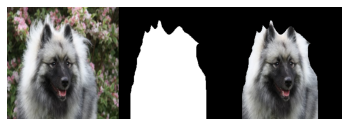

In [15]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [16]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [7]:
def unet(sz = (256, 256, 3)):
    x = Input(sz)
    inputs = x

    #down sampling 
    f = 8
    layers = []

    for i in range(0, 6):
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        layers.append(x)
        x = MaxPooling2D() (x)
        f = f*2
    ff2 = 64 

    #bottleneck 
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 

    #upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
        x = Concatenate(axis=3)([x, layers[j]])
        j = j -1 


    #classification 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    outputs = Conv2D(1, 1, activation='sigmoid') (x)

    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
    return model

In [20]:
model = unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()


i= 1 loss= 0.5965538405936602 val_loss= 0.5134382247924805 mean_iou= 0.03528866 val_mean_iou= 0.16759850084781647


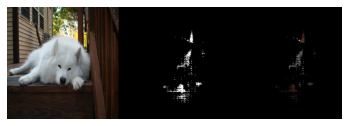

KeyboardInterrupt: 

In [23]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)